**Hierarchical Symbolic-Quantized Patching (HSQP) Implementation**
This script implements the HSQP approach for time-series tokenization,
which integrates patching, ABBA symbolic aggregation, and quantization.

The pipeline follows these steps:
1. Raw Time Series Input
2. Initial Patching (Coarse-Graining)
3. ABBA Symbolic Aggregation (Pattern Extraction)
4. Quantization of ABBA-Derived Features
5. LLM Tokenization and Embedding
6. (Optional) Inverse Transformation for forecasting/regression
"""

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from typing import List, Tuple, Dict, Union, Optional


class TimeSeriesPatching:
    """
    Class for creating patches from time series data (Step 2 in HSQP).
    """
    def __init__(self, patch_length: int = 24, stride: int = 12, overlap: bool = True):
        """
        Initialize the patching parameters.

        Args:
            patch_length: Length of each patch
            stride: Step size between patches (if overlap=True)
            overlap: Whether patches should overlap
        """
        self.patch_length = patch_length
        self.stride = stride if overlap else patch_length
        self.overlap = overlap

    def create_patches(self, time_series: np.ndarray) -> np.ndarray:
        """
        Create patches from a time series.

        Args:
            time_series: Time series data of shape [batch_size, seq_length, features]
                         or [seq_length, features] or [seq_length]

        Returns:
            Patches of shape [batch_size, num_patches, patch_length, features]
                         or [num_patches, patch_length, features]
                         or [num_patches, patch_length]
        """
        # Handle different input shapes
        original_shape = time_series.shape
        if len(original_shape) == 1:
            # Convert [seq_length] to [seq_length, 1]
            time_series = time_series.reshape(-1, 1)
            seq_length, features = time_series.shape
            batch_size = None
        elif len(original_shape) == 2:
            # [seq_length, features]
            seq_length, features = time_series.shape
            batch_size = None
        else:
            # [batch_size, seq_length, features]
            batch_size, seq_length, features = time_series.shape

        # Calculate number of patches
        num_patches = (seq_length - self.patch_length) // self.stride + 1

        if batch_size is None:
            # Initialize patches array
            patches = np.zeros((num_patches, self.patch_length, features))

            # Create patches
            for i in range(num_patches):
                start_idx = i * self.stride
                end_idx = start_idx + self.patch_length
                patches[i] = time_series[start_idx:end_idx]

            # Restore original dimensionality if input was 1D
            if len(original_shape) == 1:
                patches = patches.reshape(num_patches, self.patch_length)
        else:
            # Initialize patches array for batched data
            patches = np.zeros((batch_size, num_patches, self.patch_length, features))

            # Create patches
            for b in range(batch_size):
                for i in range(num_patches):
                    start_idx = i * self.stride
                    end_idx = start_idx + self.patch_length
                    patches[b, i] = time_series[b, start_idx:end_idx]

        return patches

    def merge_patches(self, patches: np.ndarray, original_length: Optional[int] = None) -> np.ndarray:
        """
        Merge patches back into a time series.
        For overlapping regions, values are averaged.

        Args:
            patches: Patches of shape [batch_size, num_patches, patch_length, features]
                     or [num_patches, patch_length, features]
                     or [num_patches, patch_length]
            original_length: Original sequence length (optional)

        Returns:
            Reconstructed time series
        """
        # Handle different input shapes
        original_shape = patches.shape
        if len(original_shape) == 2:
            # [num_patches, patch_length] -> [num_patches, patch_length, 1]
            patches = patches.reshape(original_shape[0], original_shape[1], 1)
            num_patches, patch_length, features = patches.shape
            batch_size = None
        elif len(original_shape) == 3:
            # [num_patches, patch_length, features]
            num_patches, patch_length, features = patches.shape
            batch_size = None
        else:
            # [batch_size, num_patches, patch_length, features]
            batch_size, num_patches, patch_length, features = patches.shape

        # Calculate reconstructed sequence length
        if original_length is None:
            seq_length = (num_patches - 1) * self.stride + patch_length
        else:
            seq_length = original_length

        if batch_size is None:
            # Initialize reconstructed time series and count array for averaging
            reconstructed = np.zeros((seq_length, features))
            counts = np.zeros((seq_length, features))

            # Merge patches
            for i in range(num_patches):
                start_idx = i * self.stride
                end_idx = start_idx + patch_length
                reconstructed[start_idx:end_idx] += patches[i]
                counts[start_idx:end_idx] += 1

            # Average overlapping regions
            reconstructed = reconstructed / np.maximum(counts, 1)

            # Restore original dimensionality if input was 2D
            if len(original_shape) == 2:
                reconstructed = reconstructed.reshape(seq_length)
        else:
            # Initialize reconstructed time series and count array for batched data
            reconstructed = np.zeros((batch_size, seq_length, features))
            counts = np.zeros((batch_size, seq_length, features))

            # Merge patches
            for b in range(batch_size):
                for i in range(num_patches):
                    start_idx = i * self.stride
                    end_idx = start_idx + patch_length
                    reconstructed[b, start_idx:end_idx] += patches[b, i]
                    counts[b, start_idx:end_idx] += 1

            # Average overlapping regions
            reconstructed = reconstructed / np.maximum(counts, 1)

        return reconstructed

In [ ]:
class ABBASymbolicAggregation:
    """
    Implementation of ABBA (Aggregation-Based Amplitude Scaling) for symbolic pattern extraction (Step 3 in HSQP).
    This is a simplified implementation based on the fABBA library concepts.
    """
    def __init__(self, tol: float = 0.1, alpha: float = 0.1, sorting: str = '2-norm', scl: float = 1, k: int = 10):
        """
        Initialize ABBA parameters.

        Args:
            tol: Tolerance for compression
            alpha: Parameter for digitization
            sorting: Method for sorting ('2-norm', 'area', etc.)
            scl: Scaling factor
            k: Number of symbols/clusters
        """
        self.tol = tol
        self.alpha = alpha
        self.sorting = sorting
        self.scl = scl
        self.k = k
        self.parameters = None
        self.kmeans = None

    def compress(self, ts: np.ndarray) -> List[Tuple[float, float]]:
        """
        Compress time series into piecewise linear segments (polygonal chain).

        Args:
            ts: Time series data

        Returns:
            List of (len, inc) tuples representing the polygonal segments
        """
        # Ensure ts is a 1D array
        ts = np.asarray(ts).flatten()
        n = len(ts)

        # Initialize
        pieces = []
        start_idx = 0

        while start_idx < n - 1:
            # Find the longest possible segment within tolerance
            end_idx = start_idx + 1
            while end_idx < n:
                # Create a line from start to current end
                if end_idx == start_idx + 1:
                    line_segment = [ts[start_idx], ts[end_idx]]
                else:
                    t = np.linspace(0, 1, end_idx - start_idx + 1)
                    line_segment = ts[start_idx] + (ts[end_idx] - ts[start_idx]) * t

                # Check if the approximation is within tolerance
                if np.max(np.abs(line_segment - ts[start_idx:end_idx+1])) <= self.tol:
                    end_idx += 1
                else:
                    end_idx -= 1
                    break

            # If we've reached the end of the time series
            if end_idx >= n:
                end_idx = n - 1

            # Calculate length and increment of the segment
            length = end_idx - start_idx
            increment = ts[end_idx] - ts[start_idx]

            # Add the segment to pieces
            pieces.append((length, increment))

            # Move to the next segment
            start_idx = end_idx

        return pieces

    def digitize(self, pieces: List[Tuple[float, float]]) -> Tuple[List[str], Dict]:
        """
        Convert polygonal segments into symbolic representation.

        Args:
            pieces: List of (len, inc) tuples

        Returns:
            string: List of symbols
            parameters: Dictionary of parameters for inverse transformation
        """
        # Extract features from pieces
        features = np.array(pieces)

        # Normalize features if needed
        if self.scl != 1:
            features = features / self.scl

        # Cluster the features
        if self.kmeans is None:
            self.kmeans = KMeans(n_clusters=self.k, random_state=0)
            self.kmeans.fit(features)

        # Get cluster assignments
        labels = self.kmeans.predict(features)

        # Convert to string representation (a, b, c, ...)
        symbols = [chr(97 + label) for label in labels]

        # Store parameters for inverse transformation
        self.parameters = {
            'centers': self.kmeans.cluster_centers_,
            'scl': self.scl,
            'alpha': self.alpha
        }

        return symbols, self.parameters

    def fit_transform(self, ts: np.ndarray) -> str:
        """
        Apply ABBA transformation to time series.

        Args:
            ts: Time series data

        Returns:
            Symbolic representation of the time series
        """
        pieces = self.compress(ts)
        symbols, _ = self.digitize(pieces)
        return ''.join(symbols)

    def inverse_transform(self, string: str, initial_value: float) -> np.ndarray:
        """
        Convert symbolic representation back to time series.

        Args:
            string: Symbolic representation
            initial_value: Initial value of the time series

        Returns:
            Reconstructed time series
        """
        if self.parameters is None:
            raise ValueError("ABBA model must be fitted before inverse transform")

        # Convert string to cluster indices
        indices = [ord(s) - 97 for s in string]

        # Get cluster centers
        centers = self.parameters['centers']

        # Scale back if needed
        if self.scl != 1:
            centers = centers * self.scl

        # Reconstruct pieces
        pieces = [tuple(centers[idx]) for idx in indices]

        # Reconstruct time series
        ts_recon = [initial_value]
        for length, increment in pieces:
            # Convert float length to integer
            length = int(round(length))
            if length < 1:
                length = 1

            # Create linear segment
            if length == 1:
                ts_recon.append(ts_recon[-1] + increment)
            else:
                for i in range(1, length + 1):
                    ts_recon.append(ts_recon[-1] + increment / length)

        return np.array(ts_recon)

In [ ]:
class FeatureQuantization:
    """
    Quantization of ABBA-derived features for efficiency optimization (Step 4 in HSQP).
    """
    def __init__(self, bit_width: int = 8, method: str = 'affine', block_size: int = 32):
        """
        Initialize quantization parameters.

        Args:
            bit_width: Target bit width (e.g., 8 for INT8, 4 for INT4)
            method: Quantization method ('affine', 'abs_max')
            block_size: Block size for block-wise quantization
        """
        self.bit_width = bit_width
        self.method = method
        self.block_size = block_size
        self.scale = None
        self.zero_point = None

        # Calculate quantization range
        self.qmin = -(2 ** (bit_width - 1))
        self.qmax = 2 ** (bit_width - 1) - 1

    def quantize(self, features: np.ndarray) -> np.ndarray:
        """
        Quantize features to lower precision.

        Args:
            features: Input features

        Returns:
            Quantized features
        """
        if self.method == 'abs_max':
            # Absolute max quantization
            abs_max = np.max(np.abs(features))
            if abs_max == 0:
                abs_max = 1.0  # Avoid division by zero

            self.scale = self.qmax / abs_max
            self.zero_point = 0

            # Quantize
            q_features = np.round(features * self.scale)
            q_features = np.clip(q_features, self.qmin, self.qmax)

        elif self.method == 'affine':
            # Affine quantization
            f_min = np.min(features)
            f_max = np.max(features)

            if f_min == f_max:
                self.scale = 1.0
                self.zero_point = 0
            else:
                self.scale = (self.qmax - self.qmin) / (f_max - f_min)
                self.zero_point = self.qmin - round(f_min * self.scale)

            # Quantize
            q_features = np.round(features * self.scale + self.zero_point)
            q_features = np.clip(q_features, self.qmin, self.qmax)

        else:
            raise ValueError(f"Unknown quantization method: {self.method}")

        return q_features.astype(np.int8 if self.bit_width <= 8 else np.int16)

    def dequantize(self, q_features: np.ndarray) -> np.ndarray:
        """
        Dequantize features back to original precision.

        Args:
            q_features: Quantized features

        Returns:
            Dequantized features
        """
        if self.scale is None or (self.method == 'affine' and self.zero_point is None):
            raise ValueError("Quantization parameters not set. Call quantize() first.")

        if self.method == 'abs_max':
            return q_features / self.scale
        elif self.method == 'affine':
            return (q_features - self.zero_point) / self.scale
        else:
            raise ValueError(f"Unknown quantization method: {self.method}")

In [ ]:
class HSQP:
    """
    Hierarchical Symbolic-Quantized Patching (HSQP) for time-series tokenization.
    """
    def __init__(self,
                 patch_length: int = 24,
                 stride: int = 12,
                 tol: float = 0.1,
                 alpha: float = 0.1,
                 k: int = 26,  # Limited to 26 for a-z symbols
                 bit_width: int = 8,
                 quant_method: str = 'affine',
                 embedding_dim: int = 64):
        """
        Initialize HSQP parameters.

        Args:
            patch_length: Length of each patch
            stride: Step size between patches
            tol: Tolerance for ABBA compression
            alpha: Parameter for ABBA digitization
            k: Number of symbols/clusters for ABBA
            bit_width: Target bit width for quantization
            quant_method: Quantization method
            embedding_dim: Dimension for LLM embedding
        """
        self.patching = TimeSeriesPatching(patch_length=patch_length, stride=stride)
        self.abba = ABBASymbolicAggregation(tol=tol, alpha=alpha, k=k)
        self.quantization = FeatureQuantization(bit_width=bit_width, method=quant_method)
        self.embedding_dim = embedding_dim

        # For LLM embedding
        self.embedding = None

    def fit_transform(self, time_series: np.ndarray) -> Tuple[List[str], np.ndarray, List[List[Tuple[float, float]]]]:
        """
        Apply HSQP transformation to time series.

        Args:
            time_series: Input time series data

        Returns:
            symbols_list: List of symbolic representations for each patch
            quantized_features: Quantized ABBA-derived features
            pieces_list: List of polygonal segments for each patch
        """
        # Step 2: Initial Patching
        patches = self.patching.create_patches(time_series)

        # Handle different input shapes
        if len(patches.shape) == 4:  # [batch_size, num_patches, patch_length, features]
            batch_size, num_patches = patches.shape[0], patches.shape[1]
            is_batched = True
        else:  # [num_patches, patch_length, features] or [num_patches, patch_length]
            num_patches = patches.shape[0]
            is_batched = False

        # Step 3: ABBA Symbolic Aggregation
        symbols_list = []
        pieces_list = []

        if is_batched:
            for b in range(batch_size):
                batch_symbols = []
                batch_pieces = []
                for i in range(num_patches):
                    # Extract patch
                    if len(patches.shape) == 4:  # [batch_size, num_patches, patch_length, features]
                        patch = patches[b, i, :, 0]  # Using first feature for simplicity

                    # Apply ABBA
                    pieces = self.abba.compress(patch)
                    symbols, _ = self.abba.digitize(pieces)

                    batch_symbols.append(''.join(symbols))
                    batch_pieces.append(pieces)

                symbols_list.append(batch_symbols)
                pieces_list.append(batch_pieces)
        else:
            for i in range(num_patches):
                # Extract patch
                if len(patches.shape) == 3:  # [num_patches, patch_length, features]
                    patch = patches[i, :, 0]  # Using first feature for simplicity
                else:  # [num_patches, patch_length]
                    patch = patches[i]

                # Apply ABBA
                pieces = self.abba.compress(patch)
                symbols, _ = self.abba.digitize(pieces)

                symbols_list.append(''.join(symbols))
                pieces_list.append(pieces)

        # Step 4: Quantization of ABBA-Derived Features
        # Extract features from pieces
        if is_batched:
            all_features = []
            for batch_pieces in pieces_list:
                batch_features = []
                for pieces in batch_pieces:
                    features = np.array(pieces)
                    batch_features.append(features)
                all_features.append(np.vstack(batch_features))
            features = np.vstack(all_features)
        else:
            all_features = []
            for pieces in pieces_list:
                features = np.array(pieces)
                all_features.append(features)
            features = np.vstack(all_features)

        # Quantize features
        quantized_features = self.quantization.quantize(features)

        return symbols_list, quantized_features, pieces_list

    def create_llm_embeddings(self, quantized_features: np.ndarray) -> np.ndarray:
        """
        Create LLM embeddings from quantized features (Step 5 in HSQP).

        Args:
            quantized_features: Quantized ABBA-derived features

        Returns:
            Embeddings for LLM
        """
        # Initialize embedding layer if not already created
        if self.embedding is None:
            input_dim = quantized_features.shape[1] if len(quantized_features.shape) > 1 else 1
            self.embedding = nn.Linear(input_dim, self.embedding_dim)

            # Initialize with random weights
            nn.init.xavier_uniform_(self.embedding.weight)
            nn.init.zeros_(self.embedding.bias)

        # Convert to torch tensor
        q_features_tensor = torch.tensor(quantized_features, dtype=torch.float32)

        # Apply embedding
        with torch.no_grad():
            embeddings = self.embedding(q_features_tensor).numpy()

        return embeddings

    def inverse_transform(self, symbols_list: List[str], initial_values: List[float], original_length: Optional[int] = None) -> np.ndarray:
        """
        Convert symbolic representation back to time series (Step 7 in HSQP).

        Args:
            symbols_list: List of symbolic representations for each patch
            initial_values: Initial values for each patch
            original_length: Original length of the time series

        Returns:
            Reconstructed time series
        """
        # Reconstruct patches
        reconstructed_patches = []

        for symbol, initial_value in zip(symbols_list, initial_values):
            # Apply ABBA inverse transform
            patch_recon = self.abba.inverse_transform(symbol, initial_value)
            reconstructed_patches.append(patch_recon)

        # Pad or truncate reconstructed patches to ensure uniform length before stacking
        # This is necessary because inverse_transform might not return the exact original patch length
        uniform_patches = []
        for p in reconstructed_patches:
            if len(p) < self.patching.patch_length:
                # Pad with zeros if shorter
                padded_patch = np.pad(p, (0, self.patching.patch_length - len(p)), 'constant')
                uniform_patches.append(padded_patch)
            else:
                # Truncate if longer, or use the first patch_length elements
                uniform_patches.append(p[:self.patching.patch_length])

        # Reshape uniform patches for merging
        # Now uniform_patches is a list of arrays with the same length
        patches_array = np.array(uniform_patches)

        # Merge patches
        reconstructed_ts = self.patching.merge_patches(patches_array, original_length)

        return reconstructed_ts


# Example usage
def example_usage():
    """
    Demonstrate the HSQP approach on a synthetic time series.
    """
    # Create a synthetic time series
    t = np.linspace(0, 10, 1000)
    ts = np.sin(t) + 0.1 * np.random.randn(1000)

    # Initialize HSQP
    hsqp = HSQP(
        patch_length=100,
        stride=50,
        tol=0.1,
        alpha=0.1,
        k=10,
        bit_width=8,
        quant_method='affine',
        embedding_dim=64
    )

    # Apply HSQP transformation
    symbols_list, quantized_features, pieces_list = hsqp.fit_transform(ts)

    # Create LLM embeddings
    embeddings = hsqp.create_llm_embeddings(quantized_features)

    # Inverse transform for reconstruction
    initial_values = [ts[i * hsqp.patching.stride] for i in range(len(symbols_list))]
    reconstructed_ts = hsqp.inverse_transform(symbols_list, initial_values, len(ts))

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(ts)
    plt.title('Original Time Series')

    plt.subplot(3, 1, 2)
    plt.plot(reconstructed_ts)
    plt.title('Reconstructed Time Series')

    plt.subplot(3, 1, 3)
    plt.plot(ts - reconstructed_ts)
    plt.title('Reconstruction Error')

    plt.tight_layout()
    plt.savefig('hsqp_example.png')
    plt.close()

    # Print summary
    print(f"Number of patches: {len(symbols_list)}")
    print(f"Symbolic representation of first patch: {symbols_list[0]}")
    print(f"Quantized features shape: {quantized_features.shape}")
    print(f"LLM embeddings shape: {embeddings.shape}")
    print(f"Reconstruction error (RMSE): {np.sqrt(np.mean((ts - reconstructed_ts)**2))}")

    return {
        'original_ts': ts,
        'reconstructed_ts': reconstructed_ts,
        'symbols_list': symbols_list,
        'quantized_features': quantized_features,
        'embeddings': embeddings
    }

In [ ]:
# Integration with fABBA library
def integrate_with_fabba(ts, patch_length=100, stride=50, tol=0.1, alpha=0.1):
    """
    Integrate the HSQP approach with the fABBA library.

    Args:
        ts: Time series data
        patch_length: Length of each patch
        stride: Step size between patches
        tol: Tolerance for ABBA compression
        alpha: Parameter for ABBA digitization

    Returns:
        Dictionary of results
    """
    try:
        from fABBA import fABBA
        from fABBA import digitize, inverse_digitize, inverse_compress

        # Step 2: Initial Patching
        patching = TimeSeriesPatching(patch_length=patch_length, stride=stride)
        patches = patching.create_patches(ts)

        # Step 3: ABBA Symbolic Aggregation using fABBA
        fabba = fABBA(tol=tol, alpha=alpha, sorting='2-norm', scl=1, verbose=0)

        symbols_list = []
        pieces_list = []
        parameters_list = []

        for i in range(len(patches)):
            patch = patches[i]

            # Apply fABBA
            string = fabba.fit_transform(patch)
            symbols_list.append(string)

            # Get pieces for quantization
            pieces, parameters = digitize(patch, alpha=alpha, sorting='2-norm', scl=2)
            pieces_list.append(pieces)
            parameters_list.append(parameters)

        # Step 4: Quantization of ABBA-Derived Features
        quantization = FeatureQuantization(bit_width=8, method='affine')

        all_features = []
        for pieces in pieces_list:
            features = np.array([(p[0], p[1]) for p in pieces])
            all_features.append(features)

        features = np.vstack(all_features)
        quantized_features = quantization.quantize(features)

        # Step 7: Inverse Transformation
        reconstructed_patches = []

        for i, (string, parameters) in enumerate(zip(symbols_list, parameters_list)):
            # Apply fABBA inverse transform
            inverse_pieces = inverse_digitize(string, parameters)
            patch_recon = inverse_compress(inverse_pieces, ts[i * stride])
            reconstructed_patches.append(patch_recon)

        # Reshape patches for merging
        patches_array = np.array([p[:patch_length] for p in reconstructed_patches])

        # Merge patches
        reconstructed_ts = patching.merge_patches(patches_array, len(ts))

        return {
            'original_ts': ts,
            'reconstructed_ts': reconstructed_ts,
            'symbols_list': symbols_list,
            'quantized_features': quantized_features
        }

    except ImportError:
        print("fABBA library not found. Using built-in ABBA implementation instead.")
        return None


if __name__ == "__main__":
    # Run example
    results = example_usage()

    # Try integration with fABBA if available
    t = np.linspace(0, 10, 1000)
    ts = np.sin(t) + 0.1 * np.random.randn(1000)
    fabba_results = integrate_with_fabba(ts)

    if fabba_results:
        print("\nResults using fABBA integration:")
        print(f"Number of patches: {len(fabba_results['symbols_list'])}")
        print(f"Symbolic representation of first patch: {fabba_results['symbols_list'][0]}")
        print(f"Quantized features shape: {fabba_results['quantized_features'].shape}")
        print(f"Reconstruction error (RMSE): {np.sqrt(np.mean((fabba_results['original_ts'] - fabba_results['reconstructed_ts'])**2))}")


Number of patches: 19
Symbolic representation of first patch: cjfcebgbacecbebcgehecdbecgbgcajebgceifbeiabecabecegbeb
Quantized features shape: (1001, 2)
LLM embeddings shape: (1001, 64)
Reconstruction error (RMSE): 0.810998229707233
fABBA library not found. Using built-in ABBA implementation instead.


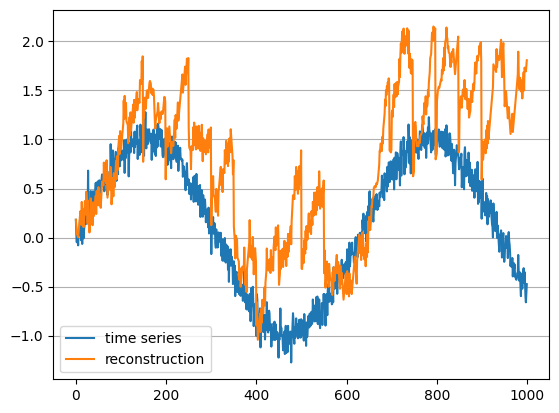

In [ ]:
plt.plot(results['original_ts'], label='time series')
plt.plot(results['reconstructed_ts'], label='reconstruction')
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [ ]:
import pandas as pd

# Load the timeseries data
try:
    timeseries_df = pd.read_csv('timeseries.csv')
    display(timeseries_df.head())
except FileNotFoundError:
    print("Error: timeseries.csv not found. Please upload the file.")
    timeseries_df = None # Set to None to avoid errors later

Error: timeseries.csv not found. Please upload the file.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your uploaded time series CSV
df = pd.read_csv('electricity.csv')

# If there's a 'Date' column, set it as index (optional)
if 'date' in df.columns: # Changed 'Date' to 'date' based on column check
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

# Extract the main time series column
# Replace 'Load' with the actual column name if different
ts = df['0'].values  # Changed 'target_WS' to '0' based on column check

In [2]:
# prompt: from the above code instead of only electricity.csv, i want used all the csv (traffic, weather and electricity)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load your uploaded time series CSVs
datasets = ['electricity.csv', 'traffic.csv', 'weather.csv']
all_ts_data = {}

for filename in datasets:
    try:
        df = pd.read_csv(filename)

        # If there's a date or timestamp column, set it as index (optional)
        date_col = None
        for col in ['date', 'Date', 'time', 'Time']:
            if col in df.columns:
                date_col = col
                break

        if date_col:
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)

        # Extract all value columns as time series
        value_cols = [col for col in df.columns if col != date_col]
        if value_cols:
            # For simplicity, let's combine all value columns into one multi-dimensional array
            # Or process each column separately if needed
            ts_data = df[value_cols].values
            all_ts_data[filename] = ts_data
            print(f"\nLoaded {filename} with shape: {ts_data.shape}")
            display(df.head())
        else:
            print(f"Warning: No value columns found in {filename} after checking for date column.")

    except FileNotFoundError:
        print(f"Error: {filename} not found. Please upload the file.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Now you can iterate through all_ts_data to process each dataset
if all_ts_data:
    for filename, ts in all_ts_data.items():
        print(f"\nProcessing data from {filename}...")

        # If the data is multi-dimensional (multiple features), process each feature separately
        # Or adapt the HSQP class to handle multi-dimensional input
        if ts.ndim > 1 and ts.shape[1] > 1:
            print(f"  Processing {ts.shape[1]} features for {filename}")
            processed_results = {}
            for i in range(ts.shape[1]):
                 print(f"    Processing feature {i}...")
                 feature_ts = ts[:, i]

                 # Initialize HSQP for each feature (or adjust to handle multi-feature)
                 hsqp = HSQP(
                     patch_length=24,  # Adjust based on your data characteristics
                     stride=12,      # Adjust based on your data characteristics
                     tol=0.1,
                     alpha=0.1,
                     k=10,
                     bit_width=8,
                     quant_method='affine',
                     embedding_dim=64
                 )

                 # Apply HSQP transformation
                 symbols_list, quantized_features, pieces_list = hsqp.fit_transform(feature_ts)

                 # Create LLM embeddings
                 embeddings = hsqp.create_llm_embeddings(quantized_features)

                 # Inverse transform for reconstruction (requires initial value for each patch)
                 # This assumes non-batched processing of each feature
                 initial_values = [feature_ts[i * hsqp.patching.stride] for i in range(len(symbols_list))]
                 reconstructed_ts = hsqp.inverse_transform(symbols_list, initial_values, len(feature_ts))

                 processed_results[f'feature_{i}'] = {
                     'original_ts': feature_ts,
                     'reconstructed_ts': reconstructed_ts,
                     'symbols_list': symbols_list,
                     'quantized_features': quantized_features,
                     'embeddings': embeddings
                 }
                 print(f"      Reconstruction error (RMSE) for feature {i}: {np.sqrt(np.mean((feature_ts - reconstructed_ts)**2))}")

            # You would typically save or further process `processed_results` for this file
            # For demonstration, let's just print summary for the first feature
            if 'feature_0' in processed_results:
                print(f"\nSummary for {filename}, feature 0:")
                print(f"  Number of patches: {len(processed_results['feature_0']['symbols_list'])}")
                print(f"  Quantized features shape: {processed_results['feature_0']['quantized_features'].shape}")
                print(f"  LLM embeddings shape: {processed_results['feature_0']['embeddings'].shape}")

                # Optional: Plot the first feature and its reconstruction
                plt.figure(figsize=(12, 4))
                plt.plot(processed_results['feature_0']['original_ts'], label='Original')
                plt.plot(processed_results['feature_0']['reconstructed_ts'], label='Reconstructed')
                plt.title(f'{filename} - Feature 0 Original vs Reconstruction')
                plt.legend()
                plt.show()


        elif ts.ndim == 1 or (ts.ndim > 1 and ts.shape[1] == 1):
             # Handle single-dimensional time series or single feature
             print("  Processing single feature...")
             # Ensure ts is 1D for ABBA
             if ts.ndim > 1:
                ts_1d = ts[:, 0]
             else:
                ts_1d = ts


             # Initialize HSQP
             hsqp = HSQP(
                 patch_length=24,  # Adjust based on your data characteristics
                 stride=12,      # Adjust based on your data characteristics
                 tol=0.1,
                 alpha=0.1,
                 k=10,
                 bit_width=8,
                 quant_method='affine',
                 embedding_dim=64
             )

             # Apply HSQP transformation
             symbols_list, quantized_features, pieces_list = hsqp.fit_transform(ts_1d)

             # Create LLM embeddings
             embeddings = hsqp.create_llm_embeddings(quantized_features)

             # Inverse transform for reconstruction
             initial_values = [ts_1d[i * hsqp.patching.stride] for i in range(len(symbols_list))]
             reconstructed_ts = hsqp.inverse_transform(symbols_list, initial_values, len(ts_1d))


             print(f"\nSummary for {filename}:")
             print(f"  Number of patches: {len(symbols_list)}")
             print(f"  Quantized features shape: {quantized_features.shape}")
             print(f"  LLM embeddings shape: {embeddings.shape}")
             print(f"  Reconstruction error (RMSE): {np.sqrt(np.mean((ts_1d - reconstructed_ts)**2))}")

             # Optional: Plot the result
             plt.figure(figsize=(12, 4))
             plt.plot(ts_1d, label='Original')
             plt.plot(reconstructed_ts, label='Reconstructed')
             plt.title(f'{filename} Original vs Reconstruction')
             plt.legend()
             plt.show()
        else:
            print(f"Warning: Data from {filename} has an unexpected shape: {ts.shape}")

else:
    print("\nNo time series data was loaded successfully.")



Loaded electricity.csv with shape: (26304, 321)


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0



Loaded traffic.csv with shape: (17544, 862)


,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
2016-07-01 03:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2016-07-01 04:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
2016-07-01 05:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
2016-07-01 06:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039



Loaded weather.csv with shape: (52696, 21)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2



Processing data from electricity.csv...
  Processing 321 features for electricity.csv
    Processing feature 0...


NameError: name 'HSQP' is not defined

In [ ]:
pd.read_csv('electricity.csv')

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


In [ ]:
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
from typing import List, Tuple, Dict, Union, Optional


class TimeSeriesPatching:
    """
    Class for creating patches from time series data (Step 2 in HSQP).
    """
    def __init__(self, patch_length: int = 24, stride: int = 12, overlap: bool = True):
        """
        Initialize the patching parameters.

        Args:
            patch_length: Length of each patch
            stride: Step size between patches (if overlap=True)
            overlap: Whether patches should overlap
        """
        self.patch_length = patch_length
        self.stride = stride if overlap else patch_length
        self.overlap = overlap

    def create_patches(self, time_series: np.ndarray) -> np.ndarray:
        """
        Create patches from a time series.

        Args:
            time_series: Time series data of shape [batch_size, seq_length, features]
                         or [seq_length, features] or [seq_length]

        Returns:
            Patches of shape [batch_size, num_patches, patch_length, features]
                         or [num_patches, patch_length, features]
                         or [num_patches, patch_length]
        """
        # Handle different input shapes
        original_shape = time_series.shape
        if len(original_shape) == 1:
            # Convert [seq_length] to [seq_length, 1]
            time_series = time_series.reshape(-1, 1)
            seq_length, features = time_series.shape
            batch_size = None
        elif len(original_shape) == 2:
            # [seq_length, features]
            seq_length, features = time_series.shape
            batch_size = None
        else:
            # [batch_size, seq_length, features]
            batch_size, seq_length, features = time_series.shape

        # Calculate number of patches
        num_patches = (seq_length - self.patch_length) // self.stride + 1

        if batch_size is None:
            # Initialize patches array
            patches = np.zeros((num_patches, self.patch_length, features))

            # Create patches
            for i in range(num_patches):
                start_idx = i * self.stride
                end_idx = start_idx + self.patch_length
                patches[i] = time_series[start_idx:end_idx]

            # Restore original dimensionality if input was 1D
            if len(original_shape) == 1:
                patches = patches.reshape(num_patches, self.patch_length)
        else:
            # Initialize patches array for batched data
            patches = np.zeros((batch_size, num_patches, self.patch_length, features))

            # Create patches
            for b in range(batch_size):
                for i in range(num_patches):
                    start_idx = i * self.stride
                    end_idx = start_idx + self.patch_length
                    patches[b, i] = time_series[b, start_idx:end_idx]

        return patches

    def merge_patches(self, patches: np.ndarray, original_length: Optional[int] = None) -> np.ndarray:
        """
        Merge patches back into a time series.
        For overlapping regions, values are averaged.

        Args:
            patches: Patches of shape [batch_size, num_patches, patch_length, features]
                     or [num_patches, patch_length, features]
                     or [num_patches, patch_length]
            original_length: Original sequence length (optional)

        Returns:
            Reconstructed time series
        """
        # Handle different input shapes
        original_shape = patches.shape
        if len(original_shape) == 2:
            # [num_patches, patch_length] -> [num_patches, patch_length, 1]
            patches = patches.reshape(original_shape[0], original_shape[1], 1)
            num_patches, patch_length, features = patches.shape
            batch_size = None
        elif len(original_shape) == 3:
            # [num_patches, patch_length, features]
            num_patches, patch_length, features = patches.shape
            batch_size = None
        else:
            # [batch_size, num_patches, patch_length, features]
            batch_size, num_patches, patch_length, features = patches.shape

        # Calculate reconstructed sequence length
        if original_length is None:
            seq_length = (num_patches - 1) * self.stride + patch_length
        else:
            seq_length = original_length

        if batch_size is None:
            # Initialize reconstructed time series and count array for averaging
            reconstructed = np.zeros((seq_length, features))
            counts = np.zeros((seq_length, features))

            # Merge patches
            for i in range(num_patches):
                start_idx = i * self.stride
                end_idx = start_idx + patch_length
                reconstructed[start_idx:end_idx] += patches[i]
                counts[start_idx:end_idx] += 1

            # Average overlapping regions
            reconstructed = reconstructed / np.maximum(counts, 1)

            # Restore original dimensionality if input was 2D
            if len(original_shape) == 2:
                reconstructed = reconstructed.reshape(seq_length)
        else:
            # Initialize reconstructed time series and count array for batched data
            reconstructed = np.zeros((batch_size, seq_length, features))
            counts = np.zeros((batch_size, seq_length, features))

            # Merge patches
            for b in range(batch_size):
                for i in range(num_patches):
                    start_idx = i * self.stride
                    end_idx = start_idx + patch_length
                    reconstructed[b, start_idx:end_idx] += patches[b, i]
                    counts[b, start_idx:end_idx] += 1

            # Average overlapping regions
            reconstructed = reconstructed / np.maximum(counts, 1)

        return reconstructed

In [ ]:
class ABBASymbolicAggregation:
    """
    Implementation of ABBA (Aggregation-Based Amplitude Scaling) for symbolic pattern extraction (Step 3 in HSQP).
    This is a simplified implementation based on the fABBA library concepts.
    """
    def __init__(self, tol: float = 0.1, alpha: float = 0.1, sorting: str = '2-norm', scl: float = 1, k: int = 10):
        """
        Initialize ABBA parameters.

        Args:
            tol: Tolerance for compression
            alpha: Parameter for digitization
            sorting: Method for sorting ('2-norm', 'area', etc.)
            scl: Scaling factor
            k: Number of symbols/clusters
        """
        self.tol = tol
        self.alpha = alpha
        self.sorting = sorting
        self.scl = scl
        self.k = k
        self.parameters = None
        self.kmeans = None

    def compress(self, ts: np.ndarray) -> List[Tuple[float, float]]:
        """
        Compress time series into piecewise linear segments (polygonal chain).

        Args:
            ts: Time series data

        Returns:
            List of (len, inc) tuples representing the polygonal segments
        """
        # Ensure ts is a 1D array
        ts = np.asarray(ts).flatten()
        n = len(ts)

        # Initialize
        pieces = []
        start_idx = 0

        while start_idx < n - 1:
            # Find the longest possible segment within tolerance
            end_idx = start_idx + 1
            while end_idx < n:
                # Create a line from start to current end
                if end_idx == start_idx + 1:
                    line_segment = [ts[start_idx], ts[end_idx]]
                else:
                    t = np.linspace(0, 1, end_idx - start_idx + 1)
                    line_segment = ts[start_idx] + (ts[end_idx] - ts[start_idx]) * t

                # Check if the approximation is within tolerance
                if np.max(np.abs(line_segment - ts[start_idx:end_idx+1])) <= self.tol:
                    end_idx += 1
                else:
                    end_idx -= 1
                    break

            # If we've reached the end of the time series
            if end_idx >= n:
                end_idx = n - 1

            # Calculate length and increment of the segment
            length = end_idx - start_idx
            increment = ts[end_idx] - ts[start_idx]

            # Add the segment to pieces
            pieces.append((length, increment))

            # Move to the next segment
            start_idx = end_idx

        return pieces

    def digitize(self, pieces: List[Tuple[float, float]]) -> Tuple[List[str], Dict]:
        """
        Convert polygonal segments into symbolic representation.

        Args:
            pieces: List of (len, inc) tuples

        Returns:
            string: List of symbols
            parameters: Dictionary of parameters for inverse transformation
        """
        # Extract features from pieces
        features = np.array(pieces)

        # Normalize features if needed
        if self.scl != 1:
            features = features / self.scl

        # Cluster the features
        if self.kmeans is None:
            self.kmeans = KMeans(n_clusters=self.k, random_state=0)
            self.kmeans.fit(features)

        # Get cluster assignments
        labels = self.kmeans.predict(features)

        # Convert to string representation (a, b, c, ...)
        symbols = [chr(97 + label) for label in labels]

        # Store parameters for inverse transformation
        self.parameters = {
            'centers': self.kmeans.cluster_centers_,
            'scl': self.scl,
            'alpha': self.alpha
        }

        return symbols, self.parameters

    def fit_transform(self, ts: np.ndarray) -> str:
        """
        Apply ABBA transformation to time series.

        Args:
            ts: Time series data

        Returns:
            Symbolic representation of the time series
        """
        pieces = self.compress(ts)
        symbols, _ = self.digitize(pieces)
        return ''.join(symbols)

    def inverse_transform(self, string: str, initial_value: float) -> np.ndarray:
        """
        Convert symbolic representation back to time series.

        Args:
            string: Symbolic representation
            initial_value: Initial value of the time series

        Returns:
            Reconstructed time series
        """
        if self.parameters is None:
            raise ValueError("ABBA model must be fitted before inverse transform")

        # Convert string to cluster indices
        indices = [ord(s) - 97 for s in string]

        # Get cluster centers
        centers = self.parameters['centers']

        # Scale back if needed
        if self.scl != 1:
            centers = centers * self.scl

        # Reconstruct pieces
        pieces = [tuple(centers[idx]) for idx in indices]

        # Reconstruct time series
        ts_recon = [initial_value]
        for length, increment in pieces:
            # Convert float length to integer
            length = int(round(length))
            if length < 1:
                length = 1

            # Create linear segment
            if length == 1:
                ts_recon.append(ts_recon[-1] + increment)
            else:
                for i in range(1, length + 1):
                    ts_recon.append(ts_recon[-1] + increment / length)

        return np.array(ts_recon)

In [ ]:
class FeatureQuantization:
    """
    Quantization of ABBA-derived features for efficiency optimization (Step 4 in HSQP).
    """
    def __init__(self, bit_width: int = 8, method: str = 'affine', block_size: int = 32):
        """
        Initialize quantization parameters.

        Args:
            bit_width: Target bit width (e.g., 8 for INT8, 4 for INT4)
            method: Quantization method ('affine', 'abs_max')
            block_size: Block size for block-wise quantization
        """
        self.bit_width = bit_width
        self.method = method
        self.block_size = block_size
        self.scale = None
        self.zero_point = None

        # Calculate quantization range
        self.qmin = -(2 ** (bit_width - 1))
        self.qmax = 2 ** (bit_width - 1) - 1

    def quantize(self, features: np.ndarray) -> np.ndarray:
        """
        Quantize features to lower precision.

        Args:
            features: Input features

        Returns:
            Quantized features
        """
        if self.method == 'abs_max':
            # Absolute max quantization
            abs_max = np.max(np.abs(features))
            if abs_max == 0:
                abs_max = 1.0  # Avoid division by zero

            self.scale = self.qmax / abs_max
            self.zero_point = 0

            # Quantize
            q_features = np.round(features * self.scale)
            q_features = np.clip(q_features, self.qmin, self.qmax)

        elif self.method == 'affine':
            # Affine quantization
            f_min = np.min(features)
            f_max = np.max(features)

            if f_min == f_max:
                self.scale = 1.0
                self.zero_point = 0
            else:
                self.scale = (self.qmax - self.qmin) / (f_max - f_min)
                self.zero_point = self.qmin - round(f_min * self.scale)

            # Quantize
            q_features = np.round(features * self.scale + self.zero_point)
            q_features = np.clip(q_features, self.qmin, self.qmax)

        else:
            raise ValueError(f"Unknown quantization method: {self.method}")

        return q_features.astype(np.int8 if self.bit_width <= 8 else np.int16)

    def dequantize(self, q_features: np.ndarray) -> np.ndarray:
        """
        Dequantize features back to original precision.

        Args:
            q_features: Quantized features

        Returns:
            Dequantized features
        """
        if self.scale is None or (self.method == 'affine' and self.zero_point is None):
            raise ValueError("Quantization parameters not set. Call quantize() first.")

        if self.method == 'abs_max':
            return q_features / self.scale
        elif self.method == 'affine':
            return (q_features - self.zero_point) / self.scale
        else:
            raise ValueError(f"Unknown quantization method: {self.method}")

In [ ]:
class HSQP:
    """
    Hierarchical Symbolic-Quantized Patching (HSQP) for time-series tokenization.
    """
    def __init__(self,
                 patch_length: int = 24,
                 stride: int = 12,
                 tol: float = 0.1,
                 alpha: float = 0.1,
                 k: int = 26,  # Limited to 26 for a-z symbols
                 bit_width: int = 8,
                 quant_method: str = 'affine',
                 embedding_dim: int = 64):
        """
        Initialize HSQP parameters.

        Args:
            patch_length: Length of each patch
            stride: Step size between patches
            tol: Tolerance for ABBA compression
            alpha: Parameter for ABBA digitization
            k: Number of symbols/clusters for ABBA
            bit_width: Target bit width for quantization
            quant_method: Quantization method
            embedding_dim: Dimension for LLM embedding
        """
        self.patching = TimeSeriesPatching(patch_length=patch_length, stride=stride)
        self.abba = ABBASymbolicAggregation(tol=tol, alpha=alpha, k=k)
        self.quantization = FeatureQuantization(bit_width=bit_width, method=quant_method)
        self.embedding_dim = embedding_dim

        # For LLM embedding
        self.embedding = None

    def fit_transform(self, time_series: np.ndarray) -> Tuple[List[str], np.ndarray, List[List[Tuple[float, float]]]]:
        """
        Apply HSQP transformation to time series.

        Args:
            time_series: Input time series data

        Returns:
            symbols_list: List of symbolic representations for each patch
            quantized_features: Quantized ABBA-derived features
            pieces_list: List of polygonal segments for each patch
        """
        # Step 2: Initial Patching
        patches = self.patching.create_patches(time_series)

        # Handle different input shapes
        if len(patches.shape) == 4:  # [batch_size, num_patches, patch_length, features]
            batch_size, num_patches = patches.shape[0], patches.shape[1]
            is_batched = True
        else:  # [num_patches, patch_length, features] or [num_patches, patch_length]
            num_patches = patches.shape[0]
            is_batched = False

        # Step 3: ABBA Symbolic Aggregation
        symbols_list = []
        pieces_list = []

        if is_batched:
            for b in range(batch_size):
                batch_symbols = []
                batch_pieces = []
                for i in range(num_patches):
                    # Extract patch
                    if len(patches.shape) == 4:  # [batch_size, num_patches, patch_length, features]
                        patch = patches[b, i, :, 0]  # Using first feature for simplicity

                    # Apply ABBA
                    pieces = self.abba.compress(patch)
                    symbols, _ = self.abba.digitize(pieces)

                    batch_symbols.append(''.join(symbols))
                    batch_pieces.append(pieces)

                symbols_list.append(batch_symbols)
                pieces_list.append(batch_pieces)
        else:
            for i in range(num_patches):
                # Extract patch
                if len(patches.shape) == 3:  # [num_patches, patch_length, features]
                    patch = patches[i, :, 0]  # Using first feature for simplicity
                else:  # [num_patches, patch_length]
                    patch = patches[i]

                # Apply ABBA
                pieces = self.abba.compress(patch)
                symbols, _ = self.abba.digitize(pieces)

                symbols_list.append(''.join(symbols))
                pieces_list.append(pieces)

        # Step 4: Quantization of ABBA-Derived Features
        # Extract features from pieces
        if is_batched:
            all_features = []
            for batch_pieces in pieces_list:
                batch_features = []
                for pieces in batch_pieces:
                    features = np.array(pieces)
                    batch_features.append(features)
                all_features.append(np.vstack(batch_features))
            features = np.vstack(all_features)
        else:
            all_features = []
            for pieces in pieces_list:
                features = np.array(pieces)
                all_features.append(features)
            features = np.vstack(all_features)

        # Quantize features
        quantized_features = self.quantization.quantize(features)

        return symbols_list, quantized_features, pieces_list

    def create_llm_embeddings(self, quantized_features: np.ndarray) -> np.ndarray:
        """
        Create LLM embeddings from quantized features (Step 5 in HSQP).

        Args:
            quantized_features: Quantized ABBA-derived features

        Returns:
            Embeddings for LLM
        """
        # Initialize embedding layer if not already created
        if self.embedding is None:
            input_dim = quantized_features.shape[1] if len(quantized_features.shape) > 1 else 1
            self.embedding = nn.Linear(input_dim, self.embedding_dim)

            # Initialize with random weights
            nn.init.xavier_uniform_(self.embedding.weight)
            nn.init.zeros_(self.embedding.bias)

        # Convert to torch tensor
        q_features_tensor = torch.tensor(quantized_features, dtype=torch.float32)

        # Apply embedding
        with torch.no_grad():
            embeddings = self.embedding(q_features_tensor).numpy()

        return embeddings

    def inverse_transform(self, symbols_list: List[str], initial_values: List[float], original_length: Optional[int] = None) -> np.ndarray:
        """
        Convert symbolic representation back to time series (Step 7 in HSQP).

        Args:
            symbols_list: List of symbolic representations for each patch
            initial_values: Initial values for each patch
            original_length: Original length of the time series

        Returns:
            Reconstructed time series
        """
        # Reconstruct patches
        reconstructed_patches = []

        for symbol, initial_value in zip(symbols_list, initial_values):
            # Apply ABBA inverse transform
            patch_recon = self.abba.inverse_transform(symbol, initial_value)
            reconstructed_patches.append(patch_recon)

        # Pad or truncate reconstructed patches to ensure uniform length before stacking
        # This is necessary because inverse_transform might not return the exact original patch length
        uniform_patches = []
        for p in reconstructed_patches:
            if len(p) < self.patching.patch_length:
                # Pad with zeros if shorter
                padded_patch = np.pad(p, (0, self.patching.patch_length - len(p)), 'constant')
                uniform_patches.append(padded_patch)
            else:
                # Truncate if longer, or use the first patch_length elements
                uniform_patches.append(p[:self.patching.patch_length])

        # Reshape uniform patches for merging
        # Now uniform_patches is a list of arrays with the same length
        patches_array = np.array(uniform_patches)

        # Merge patches
        reconstructed_ts = self.patching.merge_patches(patches_array, original_length)

        return reconstructed_ts


# Example usage
def example_usage():
    """
    Demonstrate the HSQP approach on a synthetic time series.
    """
    # Create a synthetic time series
    t = np.linspace(0, 10, 1000)
    ts = np.sin(t) + 0.1 * np.random.randn(1000)

    # Initialize HSQP
    hsqp = HSQP(
        patch_length=100,
        stride=50,
        tol=0.1,
        alpha=0.1,
        k=10,
        bit_width=8,
        quant_method='affine',
        embedding_dim=64
    )

    # Apply HSQP transformation
    symbols_list, quantized_features, pieces_list = hsqp.fit_transform(ts)

    # Create LLM embeddings
    embeddings = hsqp.create_llm_embeddings(quantized_features)

    # Inverse transform for reconstruction
    initial_values = [ts[i * hsqp.patching.stride] for i in range(len(symbols_list))]
    reconstructed_ts = hsqp.inverse_transform(symbols_list, initial_values, len(ts))

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(ts)
    plt.title('Original Time Series')

    plt.subplot(3, 1, 2)
    plt.plot(reconstructed_ts)
    plt.title('Reconstructed Time Series')

    plt.subplot(3, 1, 3)
    plt.plot(ts - reconstructed_ts)
    plt.title('Reconstruction Error')

    plt.tight_layout()
    plt.savefig('hsqp_example.png')
    plt.close()

    # Print summary
    print(f"Number of patches: {len(symbols_list)}")
    print(f"Symbolic representation of first patch: {symbols_list[0]}")
    print(f"Quantized features shape: {quantized_features.shape}")
    print(f"LLM embeddings shape: {embeddings.shape}")
    print(f"Reconstruction error (RMSE): {np.sqrt(np.mean((ts - reconstructed_ts)**2))}")

    return {
        'original_ts': ts,
        'reconstructed_ts': reconstructed_ts,
        'symbols_list': symbols_list,
        'quantized_features': quantized_features,
        'embeddings': embeddings
    }

In [ ]:
# Assuming HSQP class is already defined from your script
hsqp = HSQP(
    patch_length=50,
    stride=25,
    tol=0.1,
    alpha=0.1,
    k=10,
    bit_width=8,
    quant_method='affine',
    embedding_dim=64
)

# Apply HSQP transformation to your data
symbols_list, quantized_features, pieces_list = hsqp.fit_transform(ts)

# Create embeddings for LLM
embeddings = hsqp.create_llm_embeddings(quantized_features)

# Reconstruct time series from symbols
initial_values = [ts[i * hsqp.patching.stride] for i in range(len(symbols_list))]
reconstructed_ts = hsqp.inverse_transform(symbols_list, initial_values, len(ts))


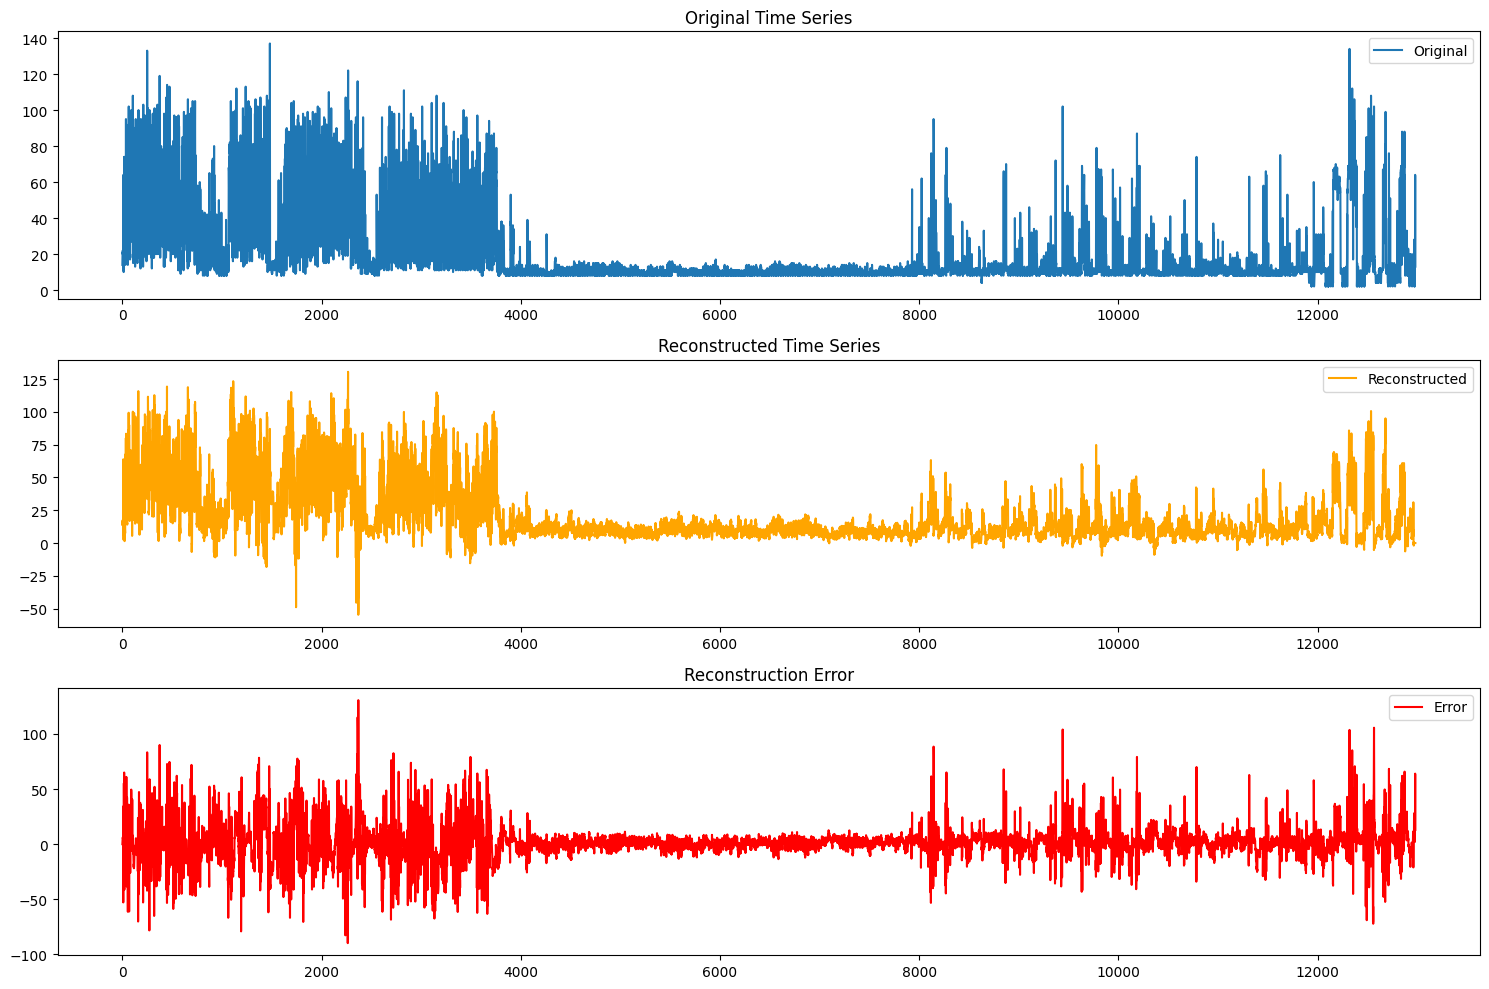

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ts, label="Original")
plt.title('Original Time Series')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(reconstructed_ts, label="Reconstructed", color='orange')
plt.title('Reconstructed Time Series')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ts - reconstructed_ts, label="Error", color='red')
plt.title('Reconstruction Error')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(f"Number of patches: {len(symbols_list)}")
print(f"First symbolic representation: {symbols_list[0]}")
print(f"Quantized features shape: {quantized_features.shape}")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Reconstruction RMSE: {np.sqrt(np.mean((ts - reconstructed_ts)**2))}")


Number of patches: 518
First symbolic representation: aahahahhefbficdicdhebbaahahhgghagbgfgjhbicjcja
Quantized features shape: (21552, 2)
Embeddings shape: (21552, 64)
Reconstruction RMSE: 14.564066045694425


In [ ]:
# prompt: i want computer RMSE, write error free code

import numpy as np
def compute_rmse(original_ts: np.ndarray, reconstructed_ts: np.ndarray) -> float:
  """
  Computes the Root Mean Squared Error (RMSE) between two time series.

  Args:
    original_ts: The original time series.
    reconstructed_ts: The reconstructed time series.

  Returns:
    The RMSE value.
  """
  # Ensure both arrays have the same length
  min_len = min(len(original_ts), len(reconstructed_ts))
  original_ts = original_ts[:min_len]
  reconstructed_ts = reconstructed_ts[:min_len]

  return np.sqrt(np.mean((original_ts - reconstructed_ts)**2))

# Compute and print the RMSE
rmse = compute_rmse(ts, reconstructed_ts)
print(f"Computed RMSE: {rmse}")

Computed RMSE: 14.564066045694425


In [ ]:
compression_ratio = len(ts) / sum(len(s) for s in symbols_list)
print("Compression Ratio:", compression_ratio)

Compression Ratio: 0.6024034892353378


The `embeddings` variable contains the numerical representations of your time series data, ready to be used as input for a pre-trained LLM like TimeGPT.

In [ ]:
# Display the shape of the embeddings
print("Shape of the LLM embeddings:", embeddings.shape)

# Display the first few embedding vectors
print("\nFirst 5 embedding vectors:")
print(embeddings[:5])

Shape of the LLM embeddings: (468, 64)

First 5 embedding vectors:
[[ 1.006132   -2.3457484  -0.58971673 -1.6209015  -1.2072785  -1.1765821
   2.823716   -2.518658    0.5563813   0.18905471  0.7488935  -0.6599743
   2.5332346  -1.0924186   2.8058228  -0.06200663 -0.51662546 -0.8405726
   0.43221545 -0.09910136 -2.6194746   2.377692   -2.3901114  -1.135118
   0.48925996  2.7880821   0.36040813 -1.1609479   0.3059432  -1.5521984
   0.71758187  2.4539533  -1.0912155  -0.707225    2.4837062  -2.2869272
   0.9894574  -0.6009076   3.5326204  -1.7062762   1.446345   -1.9790654
   2.0127106  -1.655962    0.3521635  -2.4574091  -3.7363238   3.766917
   2.0487785  -2.656723   -1.7901175  -0.96213216 -1.3483782   1.9774114
  -0.61602235  1.8648369   1.8014532  -0.9517462  -3.1928287  -0.01751049
  -3.3582356  -3.410789    1.383267   -2.9285097 ]
 [ 1.0092081  -2.2018077  -0.5446582  -1.2314605  -1.5002921  -1.2219437
   3.2845547  -2.5556922   0.6473245   0.60783345  0.82027054 -0.8604417
   2.57

In [ ]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Check if embeddings and df are available
if 'embeddings' in locals() and 'df' in locals() and 'hsqp' in locals() and 'symbols_list' in locals():
    # Use timestamps from the original DataFrame
    original_timestamps = pd.to_datetime(df.index) # Use the index which is already datetime

    # Calculate the start indices of the patches based on the stride
    patch_start_indices = [i * hsqp.patching.stride for i in range(len(symbols_list))]

    # Filter original timestamps to match the start of each patch
    # Ensure we don't go out of bounds of the original timestamps
    # Use direct indexing on the DatetimeIndex
    valid_patch_start_indices = [idx for idx in patch_start_indices if idx < len(original_timestamps)]
    aligned_timestamps = original_timestamps[valid_patch_start_indices]

    # Determine the number of embeddings and aligned timestamps
    num_embeddings = embeddings.shape[0]
    num_timestamps = len(aligned_timestamps)

    # Adjust lengths if they don't match (e.g., due to partial patches at the end)
    # We will truncate to the minimum of the two lengths
    min_length = min(num_embeddings, num_timestamps)
    embeddings_to_use = embeddings[:min_length]
    aligned_timestamps_to_use = aligned_timestamps[:min_length]

    # Create a single numerical series from embeddings (e.g., using magnitude)
    # Alternatively, you could use a specific dimension if it has meaning.
    tokenized_series_representation = np.linalg.norm(embeddings_to_use, axis=1)

    # Prepare DataFrame for TimeGPT
    df_for_timegpt = pd.DataFrame({
        'ds': aligned_timestamps_to_use,       # Aligned timestamp column
        'y': tokenized_series_representation   # Derived numerical series
    })

    # Display the new DataFrame head
    display(df_for_timegpt.head())
    print(f"\nShape of DataFrame for TimeGPT: {df_for_timegpt.shape}")

else:
    print("Error: Required variables ('embeddings', 'df', 'hsqp', or 'symbols_list') not found. Please run previous cells to generate them.")
    df_for_timegpt = None # Set to None to avoid errors later

,ds,y
0,2016-07-01 02:00:00,15.242929
1,2016-07-02 03:00:00,16.335058
2,2016-07-03 04:00:00,20.310921
3,2016-07-04 05:00:00,17.005180
4,2016-07-05 06:00:00,22.239733



Shape of DataFrame for TimeGPT: (10, 2)


In [ ]:
from nixtla import NixtlaClient
import pandas as pd

# Initialize the NixtlaClient
# Ensure you have your API key set up, e.g., in environment variables or Colab Secrets
nixtla_client = NixtlaClient(api_key='nixak-7RReF6lUGkoUEZ70JafiH9O7FmixtQXfRueIP4tOzE13zE2PvAswxA4LfkgMniu3Hhyjae9uWWS2NXt3')
# Forecast 5 future steps
forecast_horizon = 5

# Call the model using the DataFrame derived from HSQP embeddings
if 'df_for_timegpt' in locals() and df_for_timegpt is not None:
    # Ensure 'ds' column is datetime if it's not already
    df_for_timegpt['ds'] = pd.to_datetime(df_for_timegpt['ds'])

    forecast = nixtla_client.forecast(df_for_timegpt, h=forecast_horizon)

    # Show results
    print(forecast[['ds', 'TimeGPT']])
else:
    print("Error: df_for_timegpt not found. Please run the previous cell to create it.")

          ds    TimeGPT
0 2020-10-03  31.852434
1 2020-10-28  33.517387
2 2020-11-22  35.329540
3 2020-12-17  37.464355
4 2021-01-11  36.275630


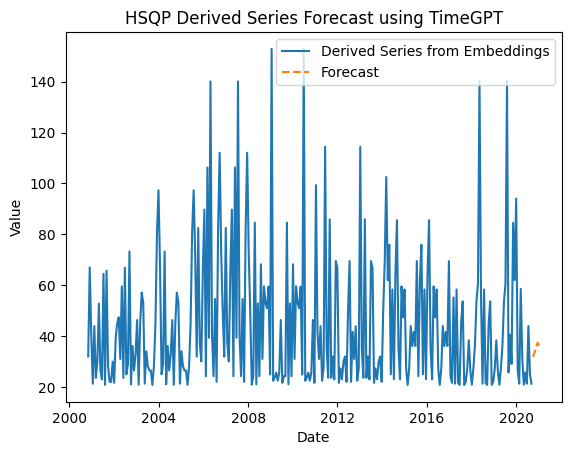

In [ ]:
import matplotlib.pyplot as plt

# Combine original and forecast
# Use df_for_timegpt for plotting the original data (derived series)
plt.plot(df_for_timegpt['ds'], df_for_timegpt['y'], label='Derived Series from Embeddings')
plt.plot(forecast['ds'], forecast['TimeGPT'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value') # Changed label as 'y' now represents embedding magnitude
plt.title('HSQP Derived Series Forecast using TimeGPT')
plt.legend()
plt.show()

In [ ]:
!pip install dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5301 sha256=372c2f3bfb8e6969fdbdc7a78322adbb07b5041d62d2611f1bcae590bd40aa38
  Stored in directory: /root/.cache/pip/wheels/2c/16/01/ffea89493a0fcd29934418eb0bf10161470acf8d5647bab656
Successfully built dtw


In [ ]:
from dtw import dtw
from scipy.spatial.distance import euclidean
import numpy as np

# Assuming symbols_list contains the symbolic representations of your patches
if 'symbols_list' in locals() and len(symbols_list) > 1:
    # For demonstration, compute DTW between the first two symbolic representations
    # DTW typically works best on numerical sequences, so we'll convert symbols to their ASCII values
    # A more sophisticated approach might involve using embeddings or other numerical features

    seq1 = [ord(c) for c in symbols_list[0]]
    seq2 = [ord(c) for c in symbols_list[1]]

    # Define a custom distance function for scalar values
    custom_dist = lambda x, y: np.abs(x - y)

    # Calculate DTW distance using the custom distance function
    distance, cost_matrix, acc_cost_matrix, path = dtw(seq1, seq2, dist=custom_dist)

    print(f"DTW distance between the first two symbolic representations: {distance}")
else:
    print("Error: symbols_list not found or does not contain enough data for DTW calculation.")

DTW distance between the first two symbolic representations: 63.0


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542095 sha256=832b9f7df70ef1aa26d9d585de390f6e4ed626880b401c9e34b59a3ee6e0c1d4
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
